# Contrastive Mutual Information Estimation

Mutual information (MI) has become a handy concept in recent years with applications in representation learning, most notably [contrastive predictive coding](https://arxiv.org/abs/1807.03748), and many other areas. While there are numerous implementations online, there is unfortunately no tutorials with intuitive explanations of the theory and implementations. In this notebook, we will do a detailed walk-through of a few popular mutual information estimators from a paper titled [On Variational Bounds of Mutual Information](https://arxiv.org/abs/1905.06922) as well as the implementations. 

Formally, mutual information quantifies the association between variables $x$ and $z$ by comparing their joint distribution $P(x, z)$ to the product of their marginals $P(x)P(z)$ using the following definition:
\begin{align}
I(X; Z) = \mathbb{E}_{P(x, z)}\left[\log\frac{P(x, z)}{P(x)P(z)}\right]
\end{align}

In representation learning, we are given a dataset $\mathcal{D} = \{x\}$ and our goal is to build a latent space using an encoder $Q_{\theta}(z|x)$. This gives us the following joint distribution $P_{\theta}(x, z) = Q_{\theta}(z|x)P(x)$ and we would like the MI evaluated under this joint distribution to be maximal. 

## Basic MI lower bound
Estimating MI is generally intractable. A popular lower bound first proposed by Barber & Agakov and has been used to learn disentangled representations in both [GANs](https://arxiv.org/abs/1606.03657) and [VAEs](https://openreview.net/forum?id=HkbmWqxCZ) can be obtained using the encoder as follows:
\begin{align}
\begin{split}
I(X; Z) &= \mathbb{E}_{P(x, z)}\left[\log\frac{P(z|x)}{P(z)}\right] \\
&= \mathbb{E}_{P(x, z)}\left[\log\frac{P(z|x)Q(z|x)}{Q(z|x)}\right] - \mathbb{E}_{P(z)}[\log P(z)] \\
&= \mathbb{E}_{P(x, z)}\left[\log Q(z|x)\right] - \mathbb{E}_{P(z)}[\log P(z)] + \mathbb{E}_{P(x)}D_{KL}(P(z|x) || Q(z|x)) \\
&\geq \mathbb{E}_{P(x, z)}\left[\log Q(z|x)\right] - \mathbb{E}_{P(z)}[\log P(z)] \triangleq I_{\text{BA}}
\end{split}
\end{align}
Estimating MI thus becomes maximizing the above bound w.r.t. $Q_{\theta}$. However, this would require us to estimate the intractable $P(z) = \int_{x}Q(z|x)P(x)$. 

## Energy based MI bounds
To solve this problem, we look to what's called energy based bounds in the variational MI bounds paper.

### TUBA lower bound
Consider energy-based distribution:
\begin{align}
Q(x|z) = \frac{P(x)e^{f(x, z)}}{Z(z)}, \text{ where } Z(z) = \mathbb{E}_{P(x)}[e^{f(x, z)}]
\end{align}

Switching the positions of $x, z$ in the BA lower bound, we get:
\begin{align}
\begin{split}
\mathbb{E}_{P(x, z)}\left[\log \frac{P(x)e^{f(x, z)}}{Z(z)}\right] = \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}[\log Z(z)] + C
\end{split}
\end{align}
where $C = \mathbb{E}_{P(x)}[\log P(x)]$.

To bound the intractable partition function $Z(\cdot)$, we use the following relationship:
\begin{align}
\log(x) \leq \frac{x}{a} + \log(a) - 1
\end{align}
which gives us the following lower bound:
\begin{align}
\begin{split}
&\mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}\left[\frac{\mathbb{E}_{P(x)}[e^{f(x, z)}]}{a(z)} + \log(a(z)) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(x)P(z)}\left[\frac{e^{f(x, z)}}{e^{\log(a(z))}} + \log(a(z)) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(x)P(z)}\left[e^{f(x, z) - \log(a(z))} + \log(a(z))\right] + 1 \triangleq I_{\text{TUBA}}
\end{split}
\end{align}
This bound is referred to as the tracktable unnormalized BA (TUBA) bound. 

The intuition of this bound is that the energy function $f$ (also called the critic) will learn to assign high value (we are using higher is better) to $x$ and $z$ sampled from the joint distribution and low value to $x$ and $z$ sampled from the marginal distributions. In other words, the (fake) marginal samples are used to contrast with the (real) joint samples, they are thus also called negative samples.

### NWJ lower bound
We may choose to set $a(z)$ to a constant $e$ and adapt the TUBA bound as follows:
\begin{align}
\begin{split}
&\mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}\left[\frac{\mathbb{E}_{P(x)}[e^{f(x, z)}]}{a(z)} + \log(a(z)) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}\left[\frac{\mathbb{E}_{P(x)}[e^{f(x, z)}]}{e} + \log(e) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - e^{-1} \mathbb{E}_{P(x)P(z)}[e^{f(x, z)}] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - e^{-1} \mathbb{E}_{P(z)}[Z(z)] \triangleq I_{\text{NWJ}}
\end{split}
\end{align}
this gives us a simplified bound originally proposed by Nguyen, Wainwright, and Jordan (NWJ). However, as in most contrastive estimators, this requires the energy function $f(x, z)$ to self-normalize, which works fine for most neural network implementations.

### InfoNCE lower bound
TUBA and NWJ typically use a singe negative sample to compute the second term. This can lead to high variance in MI estimation. The idea of what's called multi-sample bounds in the variational MI bounds paper is to leverage multiple negative samples and make $a(z)$ depends on multiple $x$'s, i.e., $a(z; x_{1:K})$. To do this, we design the energy function as:
\begin{align}
\log \frac{e^{f(x_1, z)}}{a(z; x_{1:K})}, \text{ where } a(z; x_{1:K}) = \frac{1}{K}\sum_{i=1}^{K}e^{f(x_i, z)}
\end{align}

The TUBA lower bound then becomes:
\begin{align}
\mathbb{E}_{P(x_{1:K}, z)}\left[\log \frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right] - \mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right]
\end{align}

We can show that the second term becomes 1 when averaged over $K$ samples:
\begin{align}
\begin{split}
\mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right] &= \frac{1}{K}\sum_{i=1}^{K}\mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_i, z)}}{a(z; x_{1:K})}\right] \\
&= \mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{\frac{1}{K}\sum_{i=1}^{K}e^{f(x_i, z)}}{a(z; x_{1:K})}\right] = 1
\end{split}
\end{align}

Applying the sample average and keeping only the first term, we get the InfoNCE lower bound:
\begin{align}
\mathbb{E}_{P(x_{1:K}, z)}\left[\frac{1}{K}\sum_{i=1}^{K}\log \frac{e^{f(x_i, z_i)}}{\frac{1}{K}\sum_{j=1}^{K}e^{f(x_j, z_i)}}\right] = \mathbb{E}_{P(x_{1:K}, z)}\left[\sum_{i=1}^{K}\log \frac{e^{f(x_i, z_i)}}{\sum_{j=1}^{K}e^{f(x_j, z_i)}}\right] \triangleq I_{\text{NCE}}
\end{align}

The InfoNCE bound is much more widely known, perhaps because it is easier to understand by converting the MI estimation problem into a classification problem.

## Toy example and implementation
We will implement the TUBA and NCE bound on a toy example of a mixture of Gaussians, where our goal is to learn a discrete latent space. Ideally, the discrete latent space will correspond to clustering of the dataset. 

We will parameterize the energy function as an inner product of features as is commonly done in the literature:
\begin{align}
f(x, z) = g(x)^{\intercal}g(z)
\end{align}
We will use the [Gumbel-softmax trick](https://arxiv.org/abs/1611.01144) to differentiate through the discrete latent variables. 

The main idea of our implementation of the TUBA and NCE bounds is that we will treat the $z$'s as the anchors, the true $x$'s used to compute the $z$'s as positive samples, and other batches of $x$'s randomly draw as negative samples. The difference between the two bounds, in addition to the loss function, will be how the negative sample are drawn.

We will use the following steps to compute the TUBA loss:
* Sample a batch of $x$, compute the latent $z$ for each $x$
* Sample a batch of negative samples $x_{neg}$
* Compute positive energy function $f(x, z)$
* Compute negative energy function $f(x_{neg}, z)$
* Compute baseline $\log(a(z))$
* Plug into the TUBA equation

We will use the following steps to compute the NCE loss:
* Sample a batch of $x$, compute the latent $z$ for each $x$
* Compute features $g(x)$ and $g(z)$
* Form a $K \times K$ energy matrix using einsum over the feature dimension. Off-diagonal elements in each row are serving as negative examples 
* Apply softmax function to each row
* Label the diagonal of each row as positive and apply the cross entropy classification loss

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 0
eps = 1e-6

font_size = 14
strip_size = 12

plt.rc('font', size=font_size)            # controls default text sizes
plt.rc('axes', titlesize=font_size)       # fontsize of the axes title
plt.rc('axes', labelsize=strip_size)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('ytick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('legend', fontsize=strip_size)       # legend fontsize

In [2]:
def sample_gaussian_mixture(num_samples, num_components):
    z = torch.randn(num_samples, 2)
    scale = 4
    sq2 = 1/np.sqrt(2)

    if num_components == 8:
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    else:
        centers = [(sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
    return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(num_samples,))])

In [3]:
torch.manual_seed(seed)

num_samples = 5000
x = sample_gaussian_mixture(num_samples, num_components=8).to(torch.float32)

# normalize
x -= x.mean(dim=0)
x /= x.std(dim=0)

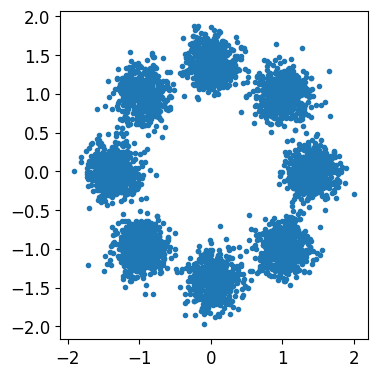

In [4]:
# plot data
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x[:, 0], x[:, 1], ".")
plt.tight_layout()
plt.show()

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.SiLU(inplace=True))
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.SiLU(inplace=True))
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class Encoder(nn.Module):
    """Output a categorical distribution"""
    def __init__(self, input_dim, output_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim, hidden_dims)
        self.tau = tau
    
    def forward(self, x):
        p = torch.softmax(self.mlp(x), dim=-1)
        return p
    
    def sample(self, x):
        p = self.forward(x)
        z = F.gumbel_softmax(torch.log(p + 1e-6), tau=self.tau, hard=True)
        return z

In [6]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

def print_grads(model):
    for n, p in model.named_parameters():
        if p is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

In [7]:
class NCE(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.encoder = Encoder(x_dim, z_dim, hidden_dims, tau=tau)
        self.critic_x = MLP(x_dim, h_dim, hidden_dims)
        self.critic_z = MLP(z_dim, h_dim, hidden_dims)

    def compute_loss(self, x, x_neg=None):
        z = self.encoder.sample(x)
        h_x = self.critic_x(x)
        h_z = self.critic_z(z)

        f = torch.einsum("ih, jh -> ij", h_z, h_x)
        p = torch.softmax(f, dim=-1)
        labels = torch.eye(len(h_x))
        loss = cross_entropy(labels, p)
        return loss.mean()
    
class TUBA(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.encoder = Encoder(x_dim, z_dim, hidden_dims, tau=tau)
        self.critic_x = MLP(x_dim, h_dim, hidden_dims)
        self.critic_z = MLP(z_dim, h_dim, hidden_dims)
        self.baseline = MLP(z_dim, 1, hidden_dims)

    def compute_loss(self, x, x_neg):
        z = self.encoder.sample(x)
        h_x_pos = self.critic_x(x)
        h_x_neg = self.critic_x(x_neg)
        h_z = self.critic_z(z)
        b_z = self.baseline(z)
        
        f_pos = torch.sum(h_x_pos * h_z, dim=-1, keepdim=True)
        f_neg = torch.sum(h_x_neg * h_z, dim=-1, keepdim=True)
        loss = f_pos - torch.exp(f_neg - b_z) - b_z + 1
        return -loss.mean()

In [36]:
def train(model, data, batch_size, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx_pos = torch.randint(len(data), size=(batch_size,))
        sample_idx_neg = torch.randint(len(data), size=(batch_size,))
        x_batch_pos = data[sample_idx_pos]
        x_batch_neg = data[sample_idx_neg]
        loss = model.compute_loss(x_batch_pos, x_batch_neg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(loss.data.item())
    return history

def plot_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(history)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.tight_layout()
    plt.show()

def plot_prediction(model, x):
    with torch.no_grad():
        z_pred = model.encoder.sample(x)
        z_conf = model.encoder.forward(x)
        
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
    ax[1].scatter(x[:, 0], x[:, 1], c=z_conf.max(-1)[0])

    ax[0].set_title("z")
    ax[1].set_title("P(z)")
    plt.tight_layout()
    plt.show()

### InfoNCE loss

In [30]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 8
h_dim = 100 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200, 200]
tau = 0.5
nce = NCE(x_dim, z_dim, h_dim, hidden_dims, tau)

batch_size = 200
lr = 3e-4
epochs = 3000
history = train(nce, x, batch_size, epochs, lr)

e: 2999, loss: 3.54: 100%|██████████| 3000/3000 [00:17<00:00, 169.16it/s]


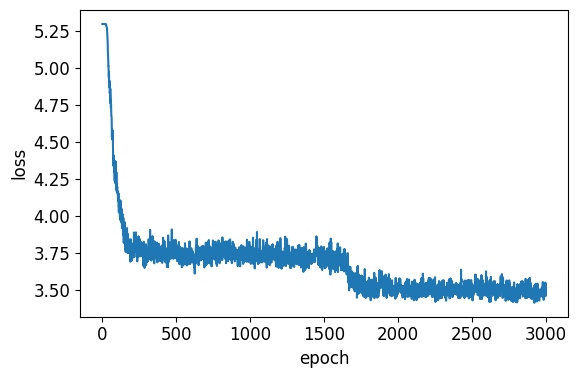

In [31]:
plot_history(history)

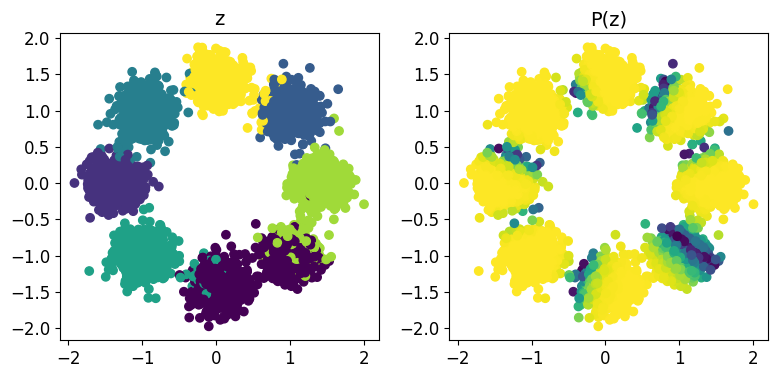

In [37]:
plot_prediction(nce, x)

### TUBA loss

In [33]:
np.random.seed(0)
torch.manual_seed(0)

x_dim = x.shape[-1]
z_dim = 8
h_dim = 100 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200, 200]
tau = 0.5
tuba = TUBA(x_dim, z_dim, h_dim, hidden_dims, tau)

batch_size = 200
lr = 3e-4
epochs = 3000
history = train(tuba, x, batch_size, epochs, lr)

e: 2999, loss: -1.59: 100%|██████████| 3000/3000 [00:24<00:00, 120.61it/s]


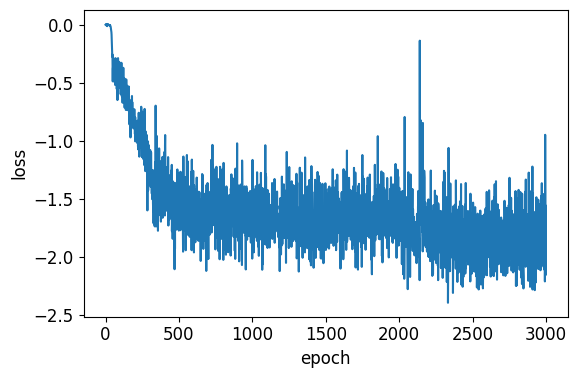

In [34]:
plot_history(history)

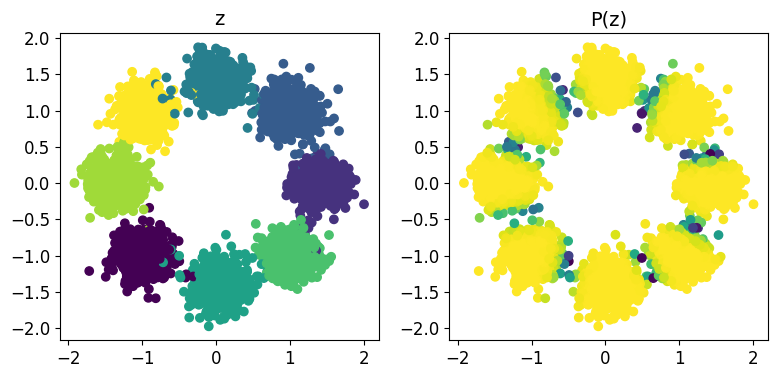

In [38]:
plot_prediction(tuba, x)

## Conclusion
We were able to learn reasonable clusters, but we were not able to recover all 8 clusters in all cases. NCE only identified 7/8 clusters but had more stable learning curve. TUBA identified all 8 clusters but has more noisy learning curve. 

In general, we should not expect MI maximization to identify perfect clusters, because MI is invarient under arbitrary invertible transformations (see discussions in [this paper](https://arxiv.org/abs/1907.13625) from a representation learning perspective and [this paper](https://arxiv.org/abs/2210.06300) from a deep clustering perspective). Nevertheless, under specific data distribution and encoder inductive biases this is possible. 